# LLM Decision Analysis Explorer

This notebook visualizes LLM decision-making patterns on ethical dilemmas, analyzing how models weigh different values (autonomy, beneficence, nonmaleficence, justice).

In [9]:
# Setup: imports and data loading
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.analysis import (
    load_decisions,
    value_preference,
    value_weights,
    bootstrap_indices,
)
from src.response_models.case import VALUE_NAMES

# Configure plotting style
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "sans-serif"

# Load decision data
decisions = load_decisions()
print(f"Loaded {len(decisions)} decision records")

# Discover available models
models = set()
for record in decisions:
    models.update(record.models.keys())
models = sorted(models)
print(f"Models: {models}")

Loaded 51 decision records
Models: ['google/gemini-3-pro-preview', 'openai/gpt-5.2']


## Value Preferences

Expected alignment E[value] for each value dimension, showing how strongly each model's choices align with each ethical value. 

- **+1**: Model consistently promotes the value
- **0**: Neutral alignment
- **-1**: Model consistently violates the value

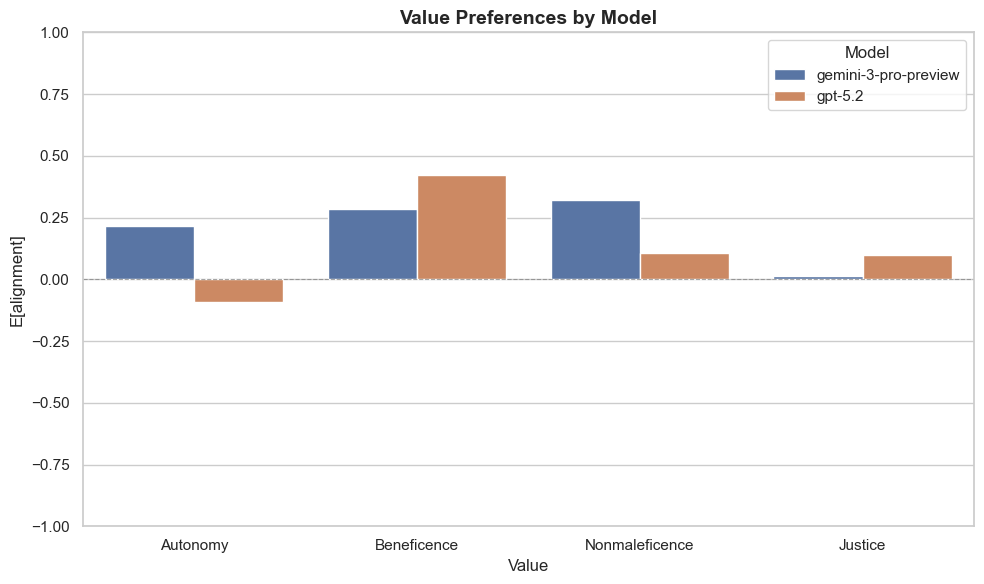

model,gemini-3-pro-preview,gpt-5.2
value,,
Autonomy,0.215,-0.090
Beneficence,0.285,0.422
Justice,0.012,0.098
Nonmaleficence,0.319,0.106


In [10]:
# Compute value preferences for each (model, value) pair
preference_data = []
for model in models:
    for value in VALUE_NAMES:
        score = value_preference(decisions, model, value)
        preference_data.append({
            "model": model.split("/")[-1],  # Short name for display
            "value": value.capitalize(),
            "alignment": score
        })

pref_df = pd.DataFrame(preference_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=pref_df, x="value", y="alignment", hue="model", ax=ax)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("E[alignment]", fontsize=12)
ax.set_title("Value Preferences by Model", fontsize=14, fontweight="bold")
ax.set_ylim(-1, 1)
ax.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()

# Display data table
pref_df.pivot(index="value", columns="model", values="alignment").round(3)

## Value Weights (Logistic Regression Coefficients)

Logistic regression coefficients (β) representing how much each value influences the model's choice probability. Positive coefficients indicate the model prefers choices that promote that value.

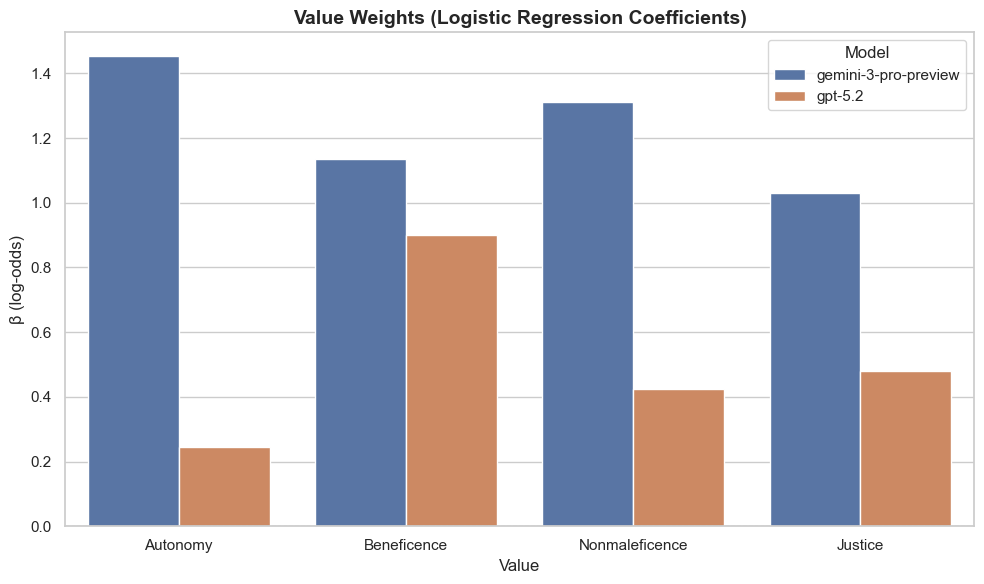

Coefficients:


model,gemini-3-pro-preview,gpt-5.2
value,,
Autonomy,1.454,0.243
Beneficence,1.134,0.900
Justice,1.031,0.480
Nonmaleficence,1.310,0.425



Standard Errors:


model,gemini-3-pro-preview,gpt-5.2
value,,
Autonomy,0.173,0.066
Beneficence,0.105,0.083
Justice,0.139,0.066
Nonmaleficence,0.144,0.073


In [11]:
# Compute value weights for each model
weights_data = []
for model in models:
    result = value_weights(decisions, model)
    for value, coef in result.coefficients.items():
        std_err = result.std_errors.get(value) if result.std_errors else None
        weights_data.append({
            "model": model.split("/")[-1],
            "value": value.capitalize(),
            "coefficient": coef,
            "std_error": std_err
        })

weights_df = pd.DataFrame(weights_data)

# Plot grouped bar chart with error bars
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=weights_df, x="value", y="coefficient", hue="model", ax=ax)
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8, alpha=0.7)
ax.set_xlabel("Value", fontsize=12)
ax.set_ylabel("β (log-odds)", fontsize=12)
ax.set_title("Value Weights (Logistic Regression Coefficients)", fontsize=14, fontweight="bold")
ax.legend(title="Model", loc="upper right")
plt.tight_layout()
plt.show()

# Display coefficients table with standard errors
pivot_coef = weights_df.pivot(index="value", columns="model", values="coefficient").round(3)
pivot_se = weights_df.pivot(index="value", columns="model", values="std_error").round(3)
print("Coefficients:")
display(pivot_coef)
print("\nStandard Errors:")
display(pivot_se)

## Model Comparison

Direct comparison between models across all value dimensions. When multiple models are available, this shows pairwise differences in value preferences.

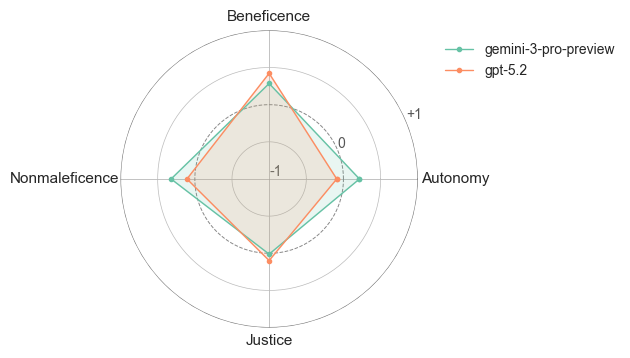

Figure: E[alignment] per value. Positive values indicate choices that promote
the value; negative values indicate choices that violate it. Dashed line = neutral.

--- Pairwise Model Differences ---

gemini-3-pro-preview vs gpt-5.2:
  Autonomy       : +0.306
  Beneficence    : -0.137
  Nonmaleficence : +0.213
  Justice        : -0.087


In [12]:
# Model comparison: radar chart for value profiles
if len(models) >= 1:
    # Axis order: Autonomy → Beneficence → Nonmaleficence → Justice (clockwise)
    values = [v.capitalize() for v in VALUE_NAMES]
    num_vars = len(values)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))
    
    # Minimal radial ticks: only -1, 0, +1
    ax.set_ylim(-1, 1)
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels(['-1', '0', '+1'], fontsize=10, color='#555555')
    
    # Radial spokes only from default grid
    ax.yaxis.grid(False)
    ax.xaxis.grid(True, color='#aaaaaa', linestyle='-', linewidth=0.5)
    
    # Draw concentric circles manually
    theta_circle = np.linspace(0, 2 * np.pi, 100)
    ax.plot(theta_circle, [-1] * 100, color='#777777', linewidth=0.8, linestyle='-', zorder=1)
    ax.plot(theta_circle, [-0.5] * 100, color='#bbbbbb', linewidth=0.5, linestyle='-', zorder=1)
    ax.plot(theta_circle, [0] * 100, color='#888888', linewidth=0.7, linestyle='--', zorder=1)
    ax.plot(theta_circle, [0.5] * 100, color='#bbbbbb', linewidth=0.5, linestyle='-', zorder=1)
    ax.plot(theta_circle, [1] * 100, color='#777777', linewidth=0.8, linestyle='-', zorder=1)
    
    # Pretty seaborn palette
    color_palette = sns.color_palette("Set2")
    
    for i, model in enumerate(models):
        model_prefs = [value_preference(decisions, model, v) for v in VALUE_NAMES]
        model_prefs += model_prefs[:1]
        
        ax.plot(angles, model_prefs, 
                marker='o', markersize=3,
                linewidth=1.0, color=color_palette[i % len(color_palette)], 
                label=model.split("/")[-1], zorder=3)
        ax.fill(angles, model_prefs, alpha=0.14, color=color_palette[i % len(color_palette)], zorder=2)
    
    # Axis labels: manually positioned for each value
    ax.set_thetagrids(np.degrees(angles[:-1]), [''] * num_vars)  # Clear default labels
    
    # Custom label positions (radial offset from edge)
    label_offsets = {
        'Autonomy': 1.5,
        'Beneficence': 1.18,
        'Nonmaleficence': 1.75,  # More space for longer word
        'Justice': 1.18
    }
    
    for angle, label in zip(angles[:-1], values):
        offset = label_offsets.get(label, 1.25)
        ax.text(angle, offset, label, fontsize=11, ha='center', va='center')
    
    # Shrink the plot area to make room for labels
    ax.set_rlim(-1, 1)
    

    
    # Legend outside, no box
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0), 
              fontsize=10, frameon=False)
    
    # Remove spines
    ax.spines['polar'].set_visible(False)
    
    fig.tight_layout()
    plt.show()
    
    # Caption for interpretation
    print("Figure: E[alignment] per value. Positive values indicate choices that promote")
    print("the value; negative values indicate choices that violate it. Dashed line = neutral.")

# Pairwise model comparison (when 2+ models available)
if len(models) >= 2:
    print("\n--- Pairwise Model Differences ---")
    for i, m1 in enumerate(models):
        for m2 in models[i+1:]:
            print(f"\n{m1.split('/')[-1]} vs {m2.split('/')[-1]}:")
            for value in VALUE_NAMES:
                p1 = value_preference(decisions, m1, value)
                p2 = value_preference(decisions, m2, value)
                diff = p1 - p2
                print(f"  {value.capitalize():15s}: {diff:+.3f}")
else:
    print("Add more models to see pairwise comparisons.")